In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

import WDM

# Regularised incomplete beta function 

The definition of the Meyer wavelet involves the regularized incomplete beta function.

$$ \nu_d(x) = \frac{ \int_0^x \mathrm{d}t \, t^{d-1} (1 - t)^{d-1} }
                        { \int_0^1 \mathrm{d}t \, t^{d-1} (1 - t)^{d-1} } . $$


This acts like a transition function (or a compact sigmoid-like function) with the output smoothly increasing from 0 to 1 as the input increases from 0 to 1.
The parameter $d$, called the steepness parameter, controls smoothness of the transition.

Here is a plot of the function $\nu_d(x)$ for several example values of $d$.

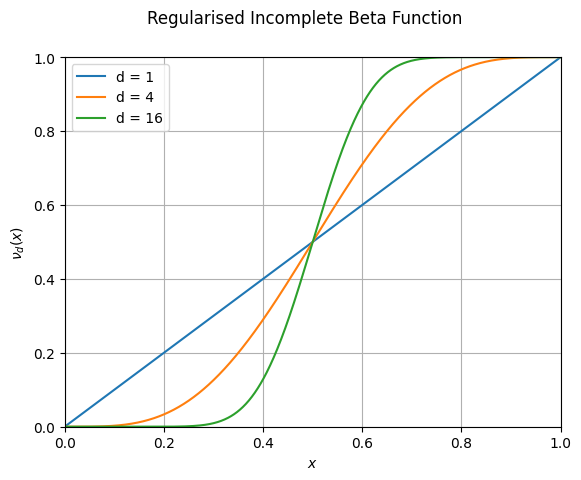

In [2]:
fig, ax = plt.subplots()
fig.suptitle("Regularised Incomplete Beta Function")

d_values = [1, 4, 16]

x = np.linspace(0, 1, 1000)
for d in d_values:
    ax.plot(x, WDM.code.utils.Meyer.nu_d(x, d), label=f"{d = }")

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\nu_d(x)$")

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.legend(loc='upper left')
plt.grid()
plt.show()


# Meyer Window

The WDM wavelets are built from the following Meyer window function.
This is defined in the frequency-domain as

$$ \Phi(\omega) = 
            \begin{cases}
            \frac{1}{\sqrt{\Delta \Omega}}, & |\omega| < A \\
            \frac{1}{\sqrt{\Delta \Omega}} \cos\left( \frac{\pi}{2} 
                \nu_d\left( \frac{|\omega| - A}{B} \right) \right), 
                & A \leq |\omega| \leq A + B \\
            0, & |\omega| > A+B
            \end{cases} . $$

Here is a nice plot of the Meyer window in both time- and frequency-domain representations.
In order to make this plot nice a smooth, the wavelet is oversampled.

Note that the wavelet is well localised (compact support) in frequency but less so in time.

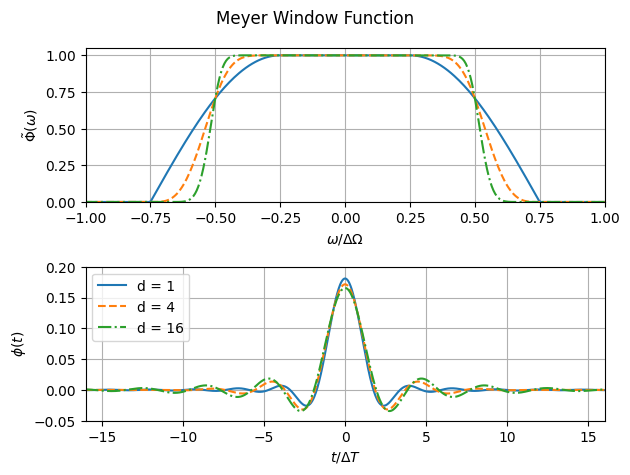

In [3]:
T = 500.
times = np.linspace(-T, T, 10000)
dt = np.mean(np.diff(times))

A, B = 0.25, 0.5
dOmega = 2 * A + B
dF = dOmega / (2*np.pi)
dT = 1 / (2*dF)

freqs = np.fft.fftfreq(len(times), d=dt)

ls = ['-', '--', '-.']
col = ['C0', 'C1', 'C2']

fig, axes = plt.subplots(nrows=2)
fig.suptitle("Meyer Window Function")

d_values = [1, 4, 16]

for i, d in enumerate(d_values):
    Phi = WDM.code.utils.Meyer.Meyer(2*np.pi*freqs, d=d, A=A, B=B) 
    Phi_centered = Phi * np.exp(-2j*np.pi*freqs*T)
    phi = np.fft.ifft(Phi_centered).real / dt
    
    omega = 2 * np.pi * np.fft.fftshift(freqs)
    axes[0].plot(omega/dOmega, np.fft.fftshift(Phi), ls=ls[i], c=col[i])
    axes[1].plot(times/dT, phi, label=f"{d = }", ls=ls[i], c=col[i])

axes[0].set_xlabel(r"$\omega/\Delta\Omega$")
axes[0].set_ylabel(r"$\tilde{\Phi}(\omega)$")

axes[0].set_xlim(-1., 1.)
axes[0].set_ylim(0., 1.05)

axes[1].set_xlabel(r"$t/\Delta T$")
axes[1].set_ylabel(r"$\phi(t)$")

axes[1].set_xlim(-16, 16)
axes[1].set_ylim(-0.05, 0.2)

axes[0].grid()
axes[1].grid()

axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

# Frequency-domain spectral representation of the wavelet basis

The wavelet basis is defined in in the frequency domain in terms of the Meyer wavelet, $\tilde{G}_{nm}(\omega)$.

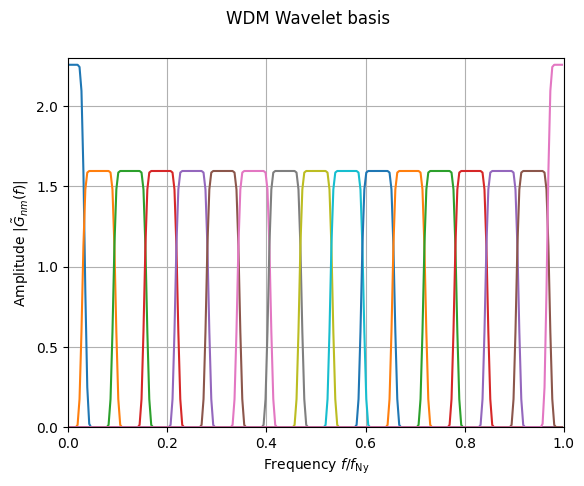

In [4]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1.0, Nf=16, N=512)

fig, ax = plt.subplots()
fig.suptitle("WDM Wavelet basis")

mask = (wdm.freqs>=0.)
for m in range(17):
    ax.plot(wdm.freqs[mask]/wdm.f_Ny, np.abs(wdm.Gnm(n=0, m=m)[mask]))

ax.set_xlabel(r"Frequency $f/f_{\rm Ny}$")
ax.set_ylabel(r"Amplitude $|\tilde{G}_{nm}(f)|$")

ax.set_xlim(0, 1)
ax.set_ylim(0, 2.3)

plt.grid()
plt.show()

# Time-domain representation of the wavelet basis

The wavelet basis in the time domain, $g_{nm}(t)$.

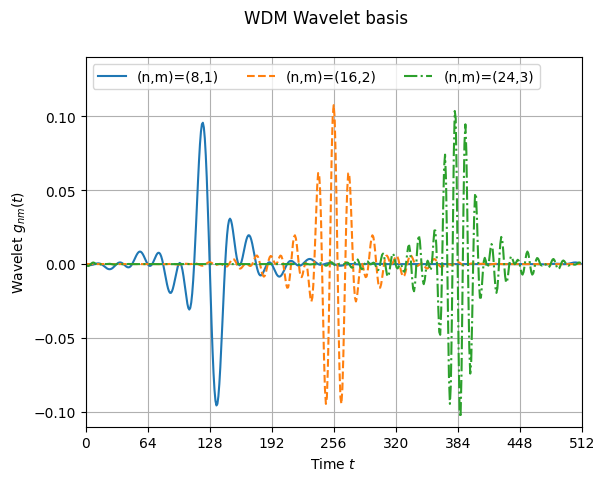

In [5]:
fig, ax = plt.subplots()
fig.suptitle("WDM Wavelet basis")

ls = ['-', '--', '-.']
col = ['C0', 'C1', 'C2']

for i, (n, m) in enumerate(zip([8, 16, 24], [1, 2, 3])):
    ax.plot(wdm.times, wdm.gnm(n=n, m=m), 
            label=f"(n,m)=({n},{m})", c=col[i], ls=ls[i])

ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"Wavelet $g_{nm}(t)$")

ax.set_xlim(0, 512)
ax.set_xticks([i*64 for i in range(9)])
ax.set_ylim(-0.11, 0.14)

ax.legend(loc='upper left', ncol=3)
plt.grid()
plt.show()

# Time-frequency representation of the wavelets basis

Here is nice visualisation of the wavelet basis in both time and frequency domains.

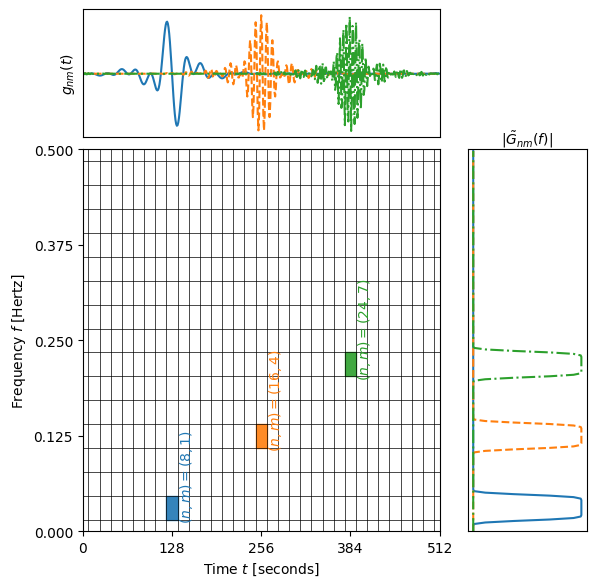

In [6]:
n_vals = [8, 16, 24]
m_vals = [1, 4, 7]

ls = ['-', '--', '-.']
col = ['C0', 'C1', 'C2', 'k']

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 0.1, 1], height_ratios=[1, 3])

# Time-domain wavelet (top-left)
ax_time = fig.add_subplot(gs[0, 0])
for i, (n, m) in enumerate(zip(n_vals, m_vals)):
    ax_time.plot(wdm.times, wdm.gnm(n=n, m=m), c=col[i], ls=ls[i])
ax_time.set_xlim(0, wdm.T)
ax_time.set_xticks([])
ax_time.set_yticks([])
ax_time.set_ylabel(r"$g_{nm}(t)$")

# Frequency-domain wavelet (bottom-right)
ax_freq = fig.add_subplot(gs[1, 2])
for i, (n, m) in enumerate(zip(n_vals, m_vals)):
    ax_freq.plot(np.abs(np.fft.fft(wdm.gnm(n=n, m=m)))[:wdm.N//2], wdm.freqs[:wdm.N//2], 
                 c=col[i], ls=ls[i])
ax_freq.set_ylim(0, wdm.f_Ny)
ax_freq.set_xticks([])
ax_freq.set_yticks([])
ax_freq.yaxis.tick_right()
ax_freq.yaxis.set_label_position("right")
ax_freq.xaxis.set_label_position('top')
ax_freq.set_xlabel(r"$|\tilde{G}_{nm}(f)|$")

# Time-frequency grid (bottom-left)
ax_tf = fig.add_subplot(gs[1, 0])
t_ticks = [(i+0.5)*wdm.dT for i in range(wdm.Nt)]
f_ticks = [(i+0.5)*wdm.dF for i in range(wdm.Nf)]
for t in t_ticks:
    ax_tf.axvline(t, color='k', lw=0.5)
for f in f_ticks:
    ax_tf.axhline(f, color='k', lw=0.5)
ax_tf.set_xlim(0, wdm.T)
ax_tf.set_ylim(0, wdm.f_Ny)
ax_tf.set_xticks(np.linspace(0, wdm.T, 5))
ax_tf.set_yticks(np.linspace(0, wdm.f_Ny, 5))
ax_tf.set_xlabel(r"Time $t$ [seconds]")
ax_tf.set_ylabel(r"Frequency $f$ [Hertz]")

def draw_rectangle(n, m, i, ax_tf, text_label=False):
    eps_x, eps_y = 0., 0.

    assert 0 <= n < wdm.Nt, f"n={n} is out of bounds for Nt={wdm.Nt}"
    assert 0 <= m < wdm.Nf, f"m={m} is out of bounds for Nf={wdm.Nf}"

    if m>0:
        if n==0:
            t0, t1 = 0, t_ticks[0]
            f0, f1 = f_ticks[m-1], f_ticks[m]
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
            if text_label:
                ax_tf.text(t1+eps_x, f0+eps_y, r"$(n,m)=("+str(n)+","+str(m)+")$", 
                        fontsize=10, color=col[i], rotation=90)
            t0, t1 = t_ticks[-1], wdm.T
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
        else:
            t0, t1 = t_ticks[n-1], t_ticks[n]
            f0, f1 = f_ticks[m-1], f_ticks[m]
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
            if text_label:
                ax_tf.text(t1+eps_x, f0+eps_y, r"$(n,m)=("+str(n)+","+str(m)+")$", 
                            fontsize=10, color=col[i], rotation=90)
    else:
        if n==0:
            t0, t1 = 0, t_ticks[1]
            f0, f1 = 0., f_ticks[0]
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
            t0, t1 = t_ticks[-1], wdm.T
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
        elif n<wdm.Nt//2:
            t0, t1 = t_ticks[2*n-1], t_ticks[2*n+1]
            f0, f1 = 0., f_ticks[0]
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
        elif n==wdm.Nt//2:
            t0, t1 = 0, t_ticks[1]
            f0, f1 = f_ticks[-1], wdm.f_Ny
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
            t0, t1 = t_ticks[-1], wdm.T
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)
        else:
            t0, t1 = t_ticks[2*(n-wdm.Nt//2)-1], t_ticks[2*(n-wdm.Nt//2)+1]
            f0, f1 = f_ticks[-1], wdm.f_Ny
            rect = patches.Rectangle((t0, f0), t1-t0, f1-f0, linewidth=1,
                            edgecolor=col[i], facecolor=col[i], alpha=0.9)
            ax_tf.add_patch(rect)


for i, (n, m) in enumerate(zip(n_vals, m_vals)):
    draw_rectangle(n, m, i, ax_tf, text_label=True)

# Remove middle unused column
fig.delaxes(fig.add_subplot(gs[0, 1]))

# Tighter layout
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.08, right=0.92, top=0.95, bottom=0.08)
plt.show()

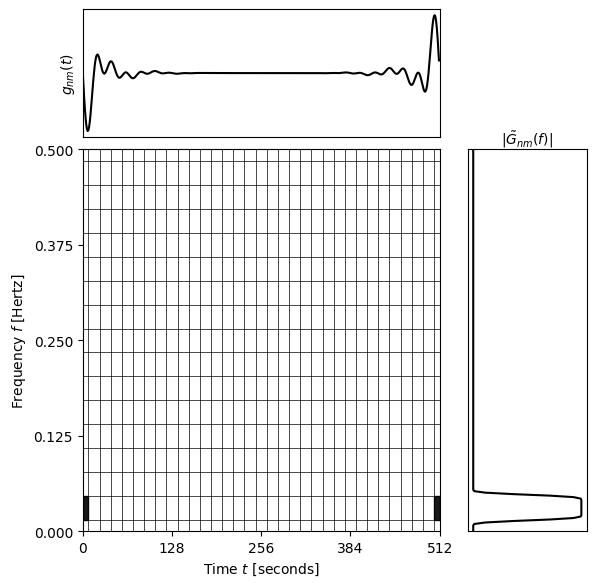

In [7]:
n = 0
m = 1

fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(2, 3, width_ratios=[3, 0.1, 1], height_ratios=[1, 3])

# Time-domain wavelet (top-left)
ax_time = fig.add_subplot(gs[0, 0])
ax_time.plot(wdm.times, wdm.gnm(n=n, m=m), 'k-')
ax_time.set_xlim(0, wdm.T)
ax_time.set_xticks([])
ax_time.set_yticks([])
ax_time.set_ylabel(r"$g_{nm}(t)$")

# Frequency-domain wavelet (bottom-right)
ax_freq = fig.add_subplot(gs[1, 2])
ax_freq.plot(np.abs(np.fft.rfft(wdm.gnm(n=n, m=m)))[:wdm.N//2], 
             wdm.freqs[:wdm.N//2], 'k-')
ax_freq.set_ylim(0, wdm.f_Ny)
ax_freq.set_xticks([])
ax_freq.set_yticks([])
ax_freq.yaxis.tick_right()
ax_freq.yaxis.set_label_position("right")
ax_freq.xaxis.set_label_position('top')
ax_freq.set_xlabel(r"$|\tilde{G}_{nm}(f)|$")

# Time-frequency grid (bottom-left)
ax_tf = fig.add_subplot(gs[1, 0])
t_ticks = [(i+0.5)*wdm.dT for i in range(wdm.Nt)]
f_ticks = [(i+0.5)*wdm.dF for i in range(wdm.Nf)]
for t in t_ticks:
    ax_tf.axvline(t, color='k', lw=0.5)
for f in f_ticks:
    ax_tf.axhline(f, color='k', lw=0.5)
ax_tf.set_xlim(0, wdm.T)
ax_tf.set_ylim(0, wdm.f_Ny)
ax_tf.set_xticks(np.linspace(0, wdm.T, 5))
ax_tf.set_yticks(np.linspace(0, wdm.f_Ny, 5))
ax_tf.set_xlabel(r"Time $t$ [seconds]")
ax_tf.set_ylabel(r"Frequency $f$ [Hertz]")
        
draw_rectangle(n, m, 3, ax_tf)

# Remove middle unused column
fig.delaxes(fig.add_subplot(gs[0, 1]))

# Tighter layout
plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.08, right=0.92, top=0.95, bottom=0.08)
plt.show()

In [8]:
"""
from PIL import Image
import io

def frame(n, m):

    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 0.1, 1], height_ratios=[1, 3])

    # Time-domain wavelet (top-left)
    ax_time = fig.add_subplot(gs[0, 0])
    ax_time.plot(wdm.times, wdm.gnm(n=n, m=m), 'k-')
    ax_time.set_xlim(0, wdm.T)
    ax_time.set_xticks([])
    ax_time.set_yticks([])
    ax_time.set_ylabel(r"$g_{nm}(t)$")

    # Frequency-domain wavelet (bottom-right)
    ax_freq = fig.add_subplot(gs[1, 2])
    ax_freq.plot(np.abs(np.fft.rfft(wdm.gnm(n=n, m=m)))[:wdm.N//2], 
                 wdm.freqs[:wdm.N//2], 'k-')
    ax_freq.set_ylim(0, wdm.f_Ny)
    ax_freq.set_xticks([])
    ax_freq.set_yticks([])
    ax_freq.yaxis.tick_right()
    ax_freq.yaxis.set_label_position("right")
    ax_freq.xaxis.set_label_position('top')
    ax_freq.set_xlabel(r"$|\tilde{G}_{nm}(f)|$")

    # Time-frequency grid (bottom-left)
    ax_tf = fig.add_subplot(gs[1, 0])
    t_ticks = [(i+0.5)*wdm.dT for i in range(wdm.Nt)]
    f_ticks = [(i+0.5)*wdm.dF for i in range(wdm.Nf)]
    for t in t_ticks:
        ax_tf.axvline(t, color='k', lw=0.5)
    for f in f_ticks:
        ax_tf.axhline(f, color='k', lw=0.5)
    ax_tf.set_xlim(0, wdm.T)
    ax_tf.set_ylim(0, wdm.f_Ny)
    ax_tf.set_xticks(np.linspace(0, wdm.T, 5))
    ax_tf.set_yticks(np.linspace(0, wdm.f_Ny, 5))
    ax_tf.set_xlabel(r"Time $t$ [seconds]")
    ax_tf.set_ylabel(r"Frequency $f$ [Hertz]")

    draw_rectangle(n, m, 3, ax_tf)

    # Remove middle unused column
    fig.delaxes(fig.add_subplot(gs[0, 1]))

    ax_label = fig.add_subplot(gs[0, 2])
    ax_label.axis("off")  # Turn off axes

    # Add your text — adjust ha/va for alignment, and fontsize as desired
    ax_label.text(1.0, 1.0, f"n={n}, m={m}", 
                ha='right', va='top', transform=ax_label.transAxes,
                fontsize=12, fontweight='bold')

    # Tighter layout
    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0.08, right=0.92, top=0.95, bottom=0.08)
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    plt.close(fig)  # Close to avoid memory issues
    buf.seek(0)

    frame = Image.open(buf).convert('RGB')

    return frame

# List to store frames
frames = []
for n in range(wdm.Nt):
    for m in range(wdm.Nf):
        frames.append(frame(n, m))

# Save as animated GIF
frames[0].save(
    'wavelet_animation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=200,  # duration per frame in ms
    loop=0  # 0 = loop forever
)
"""

'\nfrom PIL import Image\nimport io\n\ndef frame(n, m):\n\n    fig = plt.figure(figsize=(6, 6))\n    gs = gridspec.GridSpec(2, 3, width_ratios=[3, 0.1, 1], height_ratios=[1, 3])\n\n    # Time-domain wavelet (top-left)\n    ax_time = fig.add_subplot(gs[0, 0])\n    ax_time.plot(wdm.times, wdm.gnm(n=n, m=m), \'k-\')\n    ax_time.set_xlim(0, wdm.T)\n    ax_time.set_xticks([])\n    ax_time.set_yticks([])\n    ax_time.set_ylabel(r"$g_{nm}(t)$")\n\n    # Frequency-domain wavelet (bottom-right)\n    ax_freq = fig.add_subplot(gs[1, 2])\n    ax_freq.plot(np.abs(np.fft.rfft(wdm.gnm(n=n, m=m)))[:wdm.N//2], \n                 wdm.freqs[:wdm.N//2], \'k-\')\n    ax_freq.set_ylim(0, wdm.f_Ny)\n    ax_freq.set_xticks([])\n    ax_freq.set_yticks([])\n    ax_freq.yaxis.tick_right()\n    ax_freq.yaxis.set_label_position("right")\n    ax_freq.xaxis.set_label_position(\'top\')\n    ax_freq.set_xlabel(r"$|\tilde{G}_{nm}(f)|$")\n\n    # Time-frequency grid (bottom-left)\n    ax_tf = fig.add_subplot(gs[1, 0])\

# Orthonormality 

Check the orthonormalit property of the wavelets.

$$ 2 \pi \delta t \sum_{k=0}^{N-1} g_{nm}[k] g_{n'm'}[k] = \delta_{nn'} \delta_{mm'} \$$

In [12]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1.0, Nf=4, N=16)

for m in range(wdm.Nf):
    for n in range(wdm.Nt):
        for m_ in range(wdm.Nf):
            for n_ in  range(wdm.Nt):
                if n == n_ and m == m_:
                    expected = 1.0
                else:
                    expected = 0.0
                actual = np.sum(
                                wdm.gnm(n=n, m=m) * wdm.gnm(n=n_, m=m_)
                            ) * wdm.dt * 2 * np.pi
                check = np.isclose(actual, expected, rtol=1.0e-5, atol=1.0e-5)
                assert check, \
                    f"Failed for (n,m)=({n},{m}), (n',m')=({n_},{m_}): " \
                    f"expected {expected}, got {actual}"